In [2]:
import scann
import torch
import numpy as np
import pyrender
import smplx
import trimesh
import matplotlib.pyplot as plt
import os
import cv2
os.environ["PYOPENGL_PLATFORM"] = "egl"

2022-09-27 14:16:44.920754: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-27 14:16:45.001022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/nvidia:/home/zbzhu/.mujoco/mujoco200/bin:/home/zbzhu/.mujoco/mjpro150/bin
2022-09-27 14:16:45.001039: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-27 14:16:45.016657: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS whe

In [19]:
data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_11_22_34_0000--s-0/train_data-fs_15-embeds.th"
data = torch.load(data_path)
test_data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_11_22_34_0000--s-0/test_data-fs_15-embeds.th"
test_data = torch.load(test_data_path)

In [85]:
data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-32-fstep-5/basic_retrieval-embedlr_0.001-embeddim_32-fstep_5_2022_09_27_11_26_16_0000--s-0/train_data-fs_15-embeds.th"
data = torch.load(data_path)
test_data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-32-fstep-5/basic_retrieval-embedlr_0.001-embeddim_32-fstep_5_2022_09_27_11_26_16_0000--s-0/test_data-fs_15-embeds.th"
test_data = torch.load(test_data_path)

In [53]:
def normalize_angle(x):
    return torch.atan2(torch.sin(x), torch.cos(x))

def quat_to_angle_axis(q):
    # type: (Tensor) -> Tuple[Tensor, Tensor]
    # computes axis-angle representation from quaternion q
    # q must be normalized
    min_theta = 1e-5
    qx, qy, qz, qw = 0, 1, 2, 3

    sin_theta = torch.sqrt(1 - q[..., qw] * q[..., qw])
    angle = 2 * torch.acos(q[..., qw])
    angle = normalize_angle(angle)
    sin_theta_expand = sin_theta.unsqueeze(-1)
    axis = q[..., qx:qw] / sin_theta_expand

    mask = sin_theta > min_theta
    default_axis = torch.zeros_like(axis)
    default_axis[..., -1] = 1

    angle = torch.where(mask, angle, torch.zeros_like(angle))
    mask_expand = mask.unsqueeze(-1)
    axis = torch.where(mask_expand, axis, default_axis)
    return angle, axis

def angle_axis_to_exp_map(angle, axis):
    # type: (Tensor, Tensor) -> Tensor
    # compute exponential map from axis-angle
    angle_expand = angle.unsqueeze(-1)
    exp_map = angle_expand * axis
    return exp_map

def quat_to_exp_map(q):
    # type: (Tensor) -> Tensor
    # compute exponential map from quaternion
    # q must be normalized
    angle, axis = quat_to_angle_axis(q)
    exp_map = angle_axis_to_exp_map(angle, axis)
    return exp_map

def obs_visualize(obs):
    '''
    obs numpy shape (1, 4+63) root_rot + dof_pos

    #save obs for experiment
    obs_save = torch.cat((self._humanoid_root_states[:1, 3:7], self._dof_pos[:1]), dim=-1)
    obs_save = obs_save.detach().cpu().numpy()
    import datetime
    time_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    obs_folder = os.path.abspath("obs/new")
    # Create output folder if needed
    os.makedirs(obs_folder, exist_ok=True)
    savepath = os.path.join(obs_folder, time_str+".npy")
    np.save(savepath, obs_save)
    
    '''
    DOF_BODY_IDS = [3, 6, 9, 13, 16, 18, 20, 12, 15, 14, 17, 19, 21, 2, 5, 8, 11, 1, 4, 7, 10]
    body_model = 'smpl'
    body_model_path = '../assets/smpl_model/models' #share drive
    
    obs = torch.from_numpy(obs).view(-1, 1, 67)
    
    rot = torch.zeros(list(obs.shape[:-2]) + [24, 3])
    rot[..., DOF_BODY_IDS, :] = obs[..., 4:].view(list(obs.shape[:-2]) + [21, 3])
    rot[..., 0, :] = quat_to_exp_map(obs[:, 0, :4])

    body_model = smplx.create(model_path=body_model_path, model_type=body_model)
    faces = body_model.faces

    vertices = body_model(global_orient=rot[..., :1, :], body_pose=rot[..., 1:, :]).vertices[0].detach().numpy()
    # vertices = body_model().vertices[0].detach().numpy()

    original_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    # original_mesh.export('obsvistest.ply')
    mesh = pyrender.Mesh.from_trimesh(original_mesh)
    scene = pyrender.Scene(bg_color=[0, 0, 0, 0], ambient_light=(0.3, 0.3, 0.3))
    # scene = pyrender.Scene()
    scene.add(mesh, 'mesh')

    # add camera pose
    camera_pose = np.array([[1, 0, 0, 0],
                            [0, 1, 0, 0],
                            [0, 0, 1, 3],
                            [0, 0, 0, 1]])
    # use this to make it to center
    camera = pyrender.camera.PerspectiveCamera(yfov=1)
    scene.add(camera, pose=camera_pose)

    # Get the lights from the viewer
    # light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/3.0, outerConeAngle=np.pi/3.0)
    light = pyrender.SpotLight(color=100*np.ones(3), intensity=1.0, innerConeAngle=np.pi/16.0, outerConeAngle=np.pi/3.0)
    scene.add(light, pose=camera_pose)

    # offscreen render
    r = pyrender.OffscreenRenderer(viewport_width=512, viewport_height=512)
    color, depth = r.render(scene, flags=pyrender.RenderFlags.RGBA)
    # plt.figure(figsize=(8, 8))
    # plt.imshow(color[:, :, 0:3])
    # plt.show()
    # cv2.imwrite('obsvistest.png', color[:, :, 0:3])
    return color[:, :, 0:3]

In [83]:
embed = data["embeds"]
normalized_embed = embed / np.linalg.norm(embed, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_embed, 20, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

2022-09-27 14:07:42.329760: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354
2022-09-27 14:07:42.455485: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 125.671737ms.


In [6]:
selected_idxes = np.random.choice(test_data["observations"].shape[0], 4, replace=False)

test_embed = test_data["embeds"]
test_normalized_embed = test_embed / np.linalg.norm(test_embed, axis=1)[:, np.newaxis]

queries = [test_normalized_embed[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

save_dir = "../images/embed"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for batch, knn_idxes in enumerate(batch_knn_idxes):
    obs = test_data["raw_observations"][selected_idxes[batch]]
    img = obs_visualize(obs) 
    cv2.imwrite(save_dir + f'/{batch}.png', img)
    for fs in [4, 9, 14]:
        obs = test_data["raw_future_observations"][selected_idxes[batch]][fs]
        img = obs_visualize(obs) 
        cv2.imwrite(save_dir + f'/{batch}--fs-{fs + 1}.png', img)

    for i, knn_idx in enumerate(knn_idxes[:3]):
        obs = data["raw_observations"][knn_idx]
        img = obs_visualize(obs)
        cv2.imwrite(save_dir + f'/{batch}-{i}--{knn_idx}.png', img)
        # for fs in range(len(data["raw_future_observations"][knn_idx])):
        for fs in [4, 9, 14]:
            obs = data["raw_future_observations"][knn_idx][fs]
            img = obs_visualize(obs) 
            cv2.imwrite(save_dir + f'/{batch}-{i}--{knn_idx}--fs-{fs + 1}.png', img)

In [16]:
raw_obs = data["raw_observations"]
normalized_raw_obs = raw_obs / np.linalg.norm(raw_obs, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_raw_obs, 20, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

2022-09-27 12:15:41.129757: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354
2022-09-27 12:15:41.202441: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 72.629266ms.


In [17]:
test_raw_obs = test_data["raw_observations"]
test_normalized_raw_obs = test_raw_obs / np.linalg.norm(test_raw_obs, axis=1)[:, np.newaxis]

queries = [test_normalized_raw_obs[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

save_dir = "../images/raw_obs"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

for batch, knn_idxes in enumerate(batch_knn_idxes):
    obs = test_data["raw_observations"][selected_idxes[batch]]
    img = obs_visualize(obs)
    cv2.imwrite(save_dir + f'/{batch}.png', img)
    for fs in [4, 9, 14]:
        obs = test_data["raw_future_observations"][selected_idxes[batch]][fs]
        img = obs_visualize(obs) 
        cv2.imwrite(save_dir + f'/{batch}--fs-{fs + 1}.png', img)

    i = 0
    source_files = []
    for knn_idx in knn_idxes:
        if data["infos"][knn_idx][0] in source_files:
            continue
        source_files.append(data["infos"][knn_idx][0])
        i += 1
        if i > 3:
            break
        obs = data["raw_observations"][knn_idx]
        img = obs_visualize(obs) 
        cv2.imwrite(save_dir + f'/{batch}-{i}--{knn_idx}.png', img)
        # for fs in range(len(data["raw_future_observations"][knn_idx])):
        for fs in [4, 9, 14]:
            obs = data["raw_future_observations"][knn_idx][fs]
            img = obs_visualize(obs) 
            cv2.imwrite(save_dir + f'/{batch}-{i}--{knn_idx}--fs-{fs + 1}.png', img)


In [6]:
def remove_samples_from_same_files(data, selected_idxes):
    new_selected_idxes = []
    source_files = []
    for idx in selected_idxes:
        if data["infos"][idx][0] in source_files:
            continue
        source_files.append(data["infos"][idx][0])
        new_selected_idxes.append(idx)
        if len(new_selected_idxes) >= 3:
            break
    return new_selected_idxes

2022-09-27 15:01:15.517889: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354
2022-09-27 15:01:15.645379: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 127.438712ms.
2022-09-27 15:01:16.128469: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354
2022-09-27 15:01:16.199961: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 71.451878ms.
2022-09-27 15:01:17.805565: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354
2022-09-27 15:01:17.929403: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 123.788837ms.
2022-09-27 15:01:18.422828: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354


496
[[ 1261  1211  5807]
 [ 5015  4539 10615]]


2022-09-27 15:01:18.551537: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 128.665613ms.


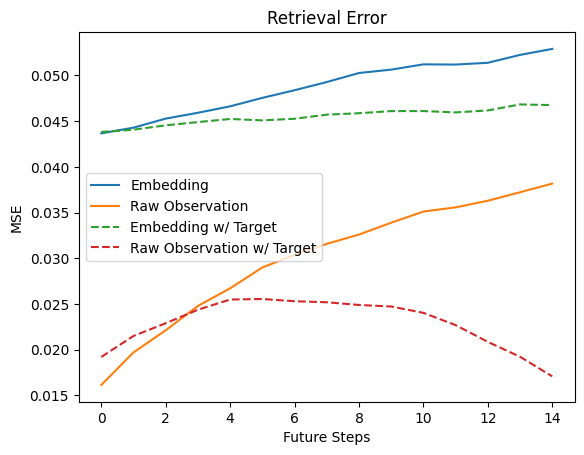

In [55]:
data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_11_22_34_0000--s-0/train_data-fs_15-embeds.th"
data = torch.load(data_path)
test_data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_11_22_34_0000--s-0/test_data-fs_15-embeds.th"
test_data = torch.load(test_data_path)

# EMBEDDING
embed = data["embeds"]
normalized_embed = embed / np.linalg.norm(embed, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_embed, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

num_samples = 500
selected_idxes = np.random.choice(test_data["observations"].shape[0], num_samples, replace=False)

test_embed = test_data["embeds"]
test_normalized_embed = test_embed / np.linalg.norm(test_embed, axis=1)[:, np.newaxis]

queries = [test_normalized_embed[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes = []
for idx in batch_knn_idxes:
    filtered_idx = remove_samples_from_same_files(data, idx)
    filtered_batch_knn_idxes.append(filtered_idx)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)

query_obs = test_data["raw_future_observations"][selected_idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Embedding")

# RAW OBS
raw_obs = data["raw_observations"]
normalized_raw_obs = raw_obs / np.linalg.norm(raw_obs, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_raw_obs, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

test_raw_obs = test_data["raw_observations"]
test_normalized_raw_obs = test_raw_obs / np.linalg.norm(test_raw_obs, axis=1)[:, np.newaxis]

queries = [test_normalized_raw_obs[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Raw Observation")

data_path = "../logs/basic-retrieval-cond-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-cond-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_13_31_29_0000--s-0/train_data-fs_15-embeds.th"
data = torch.load(data_path)
test_data_path = "../logs/basic-retrieval-cond-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-cond-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_13_31_29_0000--s-0/test_data-fs_15-embeds.th"
test_data = torch.load(test_data_path)

# EMBEDDING
embed = data["embeds"]
normalized_embed = embed / np.linalg.norm(embed, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_embed, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

test_embed = test_data["embeds"]
test_normalized_embed = test_embed / np.linalg.norm(test_embed, axis=1)[:, np.newaxis]

queries = [test_normalized_embed[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

print(len(query_obs))

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Embedding w/ Target", linestyle="--")
plt.xlabel("Future Steps")
plt.ylabel("MSE")

# RAW OBS
raw_obs = data["raw_observations"]
raw_obs = np.concatenate([raw_obs, data["raw_future_observations"][:, -1]], axis=-1)
normalized_raw_obs = raw_obs / np.linalg.norm(raw_obs, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_raw_obs, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

test_raw_obs = test_data["raw_observations"]
test_raw_obs = np.concatenate([test_raw_obs, test_data["raw_future_observations"][:, -1]], axis=-1)
test_normalized_raw_obs = test_raw_obs / np.linalg.norm(test_raw_obs, axis=1)[:, np.newaxis]

queries = [test_normalized_raw_obs[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

print(filtered_batch_knn_idxes[:2])

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Raw Observation w/ Target", linestyle="--")
plt.title("Retrieval Error")
plt.xlabel("Future Steps")
plt.ylabel("MSE")
plt.legend()

## Retrieval on Training Set

In [56]:
data_path = "../logs/basic-retrieval-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_11_22_34_0000--s-0/train_data-fs_15-embeds.th"
data = torch.load(data_path)
test_data = data

# EMBEDDING
embed = data["embeds"]
normalized_embed = embed / np.linalg.norm(embed, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_embed, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

num_samples = 500
selected_idxes = np.random.choice(test_data["observations"].shape[0], num_samples, replace=False)

test_embed = test_data["embeds"]
test_normalized_embed = test_embed / np.linalg.norm(test_embed, axis=1)[:, np.newaxis]

queries = [test_normalized_embed[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Embedding")

# RAW OBS
raw_obs = data["raw_observations"]
normalized_raw_obs = raw_obs / np.linalg.norm(raw_obs, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_raw_obs, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

test_raw_obs = test_data["raw_observations"]
test_normalized_raw_obs = test_raw_obs / np.linalg.norm(test_raw_obs, axis=1)[:, np.newaxis]

queries = [test_normalized_raw_obs[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Raw Observation")

data_path = "../logs/basic-retrieval-cond-embedlr-0.001-embeddim-128-fstep-15/basic_retrieval-cond-embedlr_0.001-embeddim_128-fstep_15_2022_09_27_13_31_29_0000--s-0/train_data-fs_15-embeds.th"
data = torch.load(data_path)
test_data = data

# EMBEDDING
embed = data["embeds"]
normalized_embed = embed / np.linalg.norm(embed, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_embed, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

test_embed = test_data["embeds"]
test_normalized_embed = test_embed / np.linalg.norm(test_embed, axis=1)[:, np.newaxis]

queries = [test_normalized_embed[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

print(len(query_obs))

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Embedding w/ Target", linestyle="--")
plt.xlabel("Future Steps")
plt.ylabel("MSE")

# RAW OBS
raw_obs = data["raw_observations"]
raw_obs = np.concatenate([raw_obs, data["raw_future_observations"][:, -1]], axis=-1)
normalized_raw_obs = raw_obs / np.linalg.norm(raw_obs, axis=1)[:, np.newaxis]
searcher = scann.scann_ops_pybind.builder(normalized_raw_obs, 30, "dot_product").tree(
    num_leaves=2000,
    num_leaves_to_search=100,
    training_sample_size=20000,
).score_ah(2, anisotropic_quantization_threshold=0.2).reorder(100).build()

test_raw_obs = test_data["raw_observations"]
test_raw_obs = np.concatenate([test_raw_obs, test_data["raw_future_observations"][:, -1]], axis=-1)
test_normalized_raw_obs = test_raw_obs / np.linalg.norm(test_raw_obs, axis=1)[:, np.newaxis]

queries = [test_normalized_raw_obs[idx] for idx in selected_idxes]
batch_knn_idxes = searcher.search_batched(queries)[0]

filtered_batch_knn_idxes, idxes = [], []
for i, idx in enumerate(batch_knn_idxes):
    filtered_idx = remove_samples_from_same_files(data, idx)
    if len(filtered_idx) < 3:
        continue
    filtered_batch_knn_idxes.append(filtered_idx)
    idxes.append(i)
filtered_batch_knn_idxes = np.array(filtered_batch_knn_idxes)
idxes = np.array(idxes)

print(filtered_batch_knn_idxes[:2])

query_obs = test_data["raw_future_observations"][selected_idxes][idxes]
batch_knn_obs = data["raw_future_observations"][filtered_batch_knn_idxes]

knn_obs_diff = ((np.expand_dims(query_obs, 1) - batch_knn_obs) ** 2).mean(axis=-1).mean(axis=1).mean(axis=0)
# PLOT
plt.plot(knn_obs_diff, label="Raw Observation w/ Target", linestyle="--")
plt.title("Retrieval Error")
plt.xlabel("Future Steps")
plt.ylabel("MSE")
plt.legend()

2022-09-27 15:04:21.816256: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 11354
2022-09-27 15:04:21.941467: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 125.156042ms.
/home/zbzhu/miniconda3/envs/motion/lib/python3.7/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


IndexError: arrays used as indices must be of integer (or boolean) type